<a href="https://colab.research.google.com/github/AubinGil/XRAY_classifier-/blob/main/chest_xray_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download_chestxray_subset.py

import os
import requests
import zipfile
import tarfile
import shutil

# === CONFIG ===
REPO_ZIP_URL     = "https://github.com/MichaelNoya/nih-chest-xray-webdataset-subset/archive/refs/heads/main.zip"
ZIP_FILENAME     = "subset.zip"
EXTRACT_DIR      = "repo_extract"
OUTPUT_DIR       = "chestxray_data"
IMAGES_DIR       = os.path.join(OUTPUT_DIR, "images")
TRAIN_LABELS_DIR = os.path.join(OUTPUT_DIR, "train_labels")
TEST_LABELS_DIR  = os.path.join(OUTPUT_DIR, "test_labels")
# ==============

def download_zip(url, dest):
    print(f"Downloading {url} …")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(dest, "wb") as f:
            for chunk in r.iter_content(8192):
                f.write(chunk)
    print("Download complete.")

def extract_zip(zip_path, dest_dir):
    print(f"Extracting {zip_path} to {dest_dir} …")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(dest_dir)
    print("ZIP extraction complete.")

def extract_all_tars(src_root, images_out):
    print(f"Looking for .tar files under {src_root} …")
    for root, _, files in os.walk(src_root):
        for fn in files:
            if fn.endswith(".tar"):
                tar_path = os.path.join(root, fn)
                print(f"  → Extracting {fn}")
                with tarfile.open(tar_path, "r") as t:
                    t.extractall(images_out)
    print("All .tar shards extracted.")

def copy_labels(src_labels, dest_dir, filename):
    os.makedirs(dest_dir, exist_ok=True)
    src_file = os.path.join(src_labels, filename)
    if not os.path.isfile(src_file):
        raise FileNotFoundError(f"{filename} not found in {src_labels}")
    shutil.copy2(src_file, dest_dir)
    print(f"Copied {filename} → {dest_dir}")

def cleanup(zip_f, extract_dir):
    print("Cleaning up …")
    if os.path.exists(zip_f):
        os.remove(zip_f)
    if os.path.isdir(extract_dir):
        shutil.rmtree(extract_dir)
    print("Cleanup done.")

if __name__ == "__main__":
    # 0) Prep output dirs
    os.makedirs(IMAGES_DIR, exist_ok=True)
    os.makedirs(TRAIN_LABELS_DIR, exist_ok=True)
    os.makedirs(TEST_LABELS_DIR, exist_ok=True)

    # 1) Download & unzip
    download_zip(REPO_ZIP_URL, ZIP_FILENAME)
    extract_zip(ZIP_FILENAME, EXTRACT_DIR)

    # 2) Locate repo root
    repo_root = next(
        os.path.join(EXTRACT_DIR, d)
        for d in os.listdir(EXTRACT_DIR)
        if os.path.isdir(os.path.join(EXTRACT_DIR, d))
    )

    # 3) Extract images
    extract_all_tars(os.path.join(repo_root, "datasets"), IMAGES_DIR)

    # 4) Copy train & test labels
    labels_src = os.path.join(repo_root, "labels")
    copy_labels(labels_src, TRAIN_LABELS_DIR, "train_labels.csv")
    copy_labels(labels_src, TEST_LABELS_DIR,  "test_labels.csv")

    # 5) Cleanup
    cleanup(ZIP_FILENAME, EXTRACT_DIR)

    # Summary
    total_imgs = sum(len(files) for _,_,files in os.walk(IMAGES_DIR))
    print(f"\n✅ Done! {total_imgs} images in {IMAGES_DIR}")
    print(f"✅ train_labels.csv in {TRAIN_LABELS_DIR}")
    print(f"✅ test_labels.csv  in {TEST_LABELS_DIR}")


Download complete.
Extracting subset.zip to repo_extract …
ZIP extraction complete.
Looking for .tar files under repo_extract/nih-chest-xray-webdataset-subset-main/datasets …
  → Extracting ChestXray14_val_000.tar
  → Extracting ChestXray14_train_003.tar
  → Extracting ChestXray14_train_021.tar
  → Extracting ChestXray14_test_003.tar
  → Extracting ChestXray14_test_005.tar
  → Extracting ChestXray14_train_002.tar
  → Extracting ChestXray14_test_006.tar
  → Extracting ChestXray14_test_000.tar
  → Extracting ChestXray14_train_012.tar
  → Extracting ChestXray14_train_001.tar
  → Extracting ChestXray14_train_000.tar
  → Extracting ChestXray14_train_014.tar
  → Extracting ChestXray14_train_015.tar
  → Extracting ChestXray14_train_017.tar
  → Extracting ChestXray14_val_001.tar
  → Extracting ChestXray14_test_001.tar
  → Extracting ChestXray14_train_010.tar
  → Extracting ChestXray14_train_011.tar
  → Extracting ChestXray14_train_004.tar
  → Extracting ChestXray14_val_002.tar
  → Extracting C

In [ ]:
# prompt: In this notebook i implemented a inception v3 can you implement a VIT transformer for multiclass classification so we can compare

!pip install transformers torch torchvision torchaudio pandas scikit-learn

import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
# Adjust based on your data
ALL_LABELS = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

# --- Data Preparation ---

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, label_binarizer=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_binarizer = label_binarizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        # Correctly extract labels using ALL_LABELS
        labels = self.dataframe.iloc[idx][ALL_LABELS].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels, dtype=torch.float32)

# Load labels
train_df = pd.read_csv(os.path.join(TRAIN_LABELS_DIR, 'train_labels.csv'))
test_df = pd.read_csv(os.path.join(TEST_LABELS_DIR, 'test_labels.csv'))

# Binarize labels
mlb = MultiLabelBinarizer()
mlb.fit([ALL_LABELS]) # Fit on all possible labels to ensure consistent columns

# Split training data for validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define transforms
transform = Compose([
    Resize(IMAGE_SIZE),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_df, IMAGES_DIR, transform=transform) # Removed label_binarizer
val_dataset = ChestXrayDataset(val_df, IMAGES_DIR, transform=transform) # Removed label_binarizer
test_dataset = ChestXrayDataset(test_df, IMAGES_DIR, transform=transform) # Removed label_binarizer

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# --- Model Definition ---

# Load pre-trained ViT model
# We will replace the classifier head for multi-label classification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')

# Modify the classifier head for multi-label classification
# The number of output classes should match the number of unique labels
num_labels = len(ALL_LABELS) # Use len(ALL_LABELS) instead of mlb.classes_
model.classifier = nn.Linear(model.config.hidden_size, num_labels)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for multi-label classification
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images).logits # Get logits for multi-label
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {epoch_loss:.4f}")

    # --- Validation Loop ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)

    val_loss = running_val_loss / len(val_dataset)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {val_loss:.4f}")

print("Training finished.")

# --- Evaluation ---
print("Evaluating on test set...")
model.eval()
running_test_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * images.size(0)

        # For multi-label, we typically threshold the sigmoid output
        # Here we get the raw logits, apply sigmoid later if needed for metrics
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# You would typically calculate metrics like AUC-ROC, F1-score for multi-label
# using the `predictions` and `true_labels` arrays.
# Example (requires sklearn):
from sklearn.metrics import roc_auc_score, f1_score

# Apply sigmoid to get probabilities for AUC/F1 (assuming outputs are logits)
import numpy as np
sigmoid_predictions = 1 / (1 + np.exp(-np.array(predictions)))
true_labels = np.array(true_labels) # Convert true_labels to a numpy array


# Calculate AUC for each label (One vs Rest)
# Handle cases where a label might be missing in the test set true_labels
aucs = []
for i in range(true_labels.shape[1]):
    try:
        auc = roc_auc_score(true_labels[:, i], sigmoid_predictions[:, i])
        aucs.append(auc)
    except ValueError:
        # Handle cases where a class might have only one sample in the test set
        # print(f"Could not calculate AUC for label {mlb.classes_[i]}")
        pass # Or handle as needed

mean_auc = np.mean(aucs) if aucs else 0
print(f"Mean AUC-ROC: {mean_auc:.4f}")

# For F1, you typically need to choose a threshold. A common approach is 0.5
# binary_predictions = (sigmoid_predictions > 0.5).astype(int)
# micro_f1 = f1_score(true_labels, binary_predictions, average='micro')
# macro_f1 = f1_score(true_labels, binary_predictions, average='macro')
# print(f"Micro F1 Score: {micro_f1:.4f}")
# print(f"Macro F1 Score: {macro_f1:.4f}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch 1/5 - Training:   0%|          | 0/1059 [00:00<?, ?it/s]

Epoch 1/5, Training Loss: 0.1907


Epoch 1/5 - Validation:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 1/5, Validation Loss: 0.1710


Epoch 2/5 - Training:   0%|          | 0/1059 [00:00<?, ?it/s]

Epoch 2/5, Training Loss: 0.1639


Epoch 2/5 - Validation:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 2/5, Validation Loss: 0.1644


Epoch 3/5 - Training:   0%|          | 0/1059 [00:00<?, ?it/s]

Epoch 3/5, Training Loss: 0.1541


Epoch 3/5 - Validation:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 3/5, Validation Loss: 0.1602


Epoch 4/5 - Training:   0%|          | 0/1059 [00:00<?, ?it/s]

Epoch 4/5, Training Loss: 0.1416


Epoch 4/5 - Validation:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 4/5, Validation Loss: 0.1651


Epoch 5/5 - Training:   0%|          | 0/1059 [00:00<?, ?it/s]

Epoch 5/5, Training Loss: 0.1248


Epoch 5/5 - Validation:   0%|          | 0/265 [00:00<?, ?it/s]

Epoch 5/5, Validation Loss: 0.1696
Training finished.
Evaluating on test set...


Evaluating:   0%|          | 0/405 [00:00<?, ?it/s]

Test Loss: 0.1701
Mean AUC-ROC: 0.7594


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import ViTForImageClassification
from sklearn.metrics import roc_auc_score
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


# Define constants
# Adjust based on your data
ALL_LABELS = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10 # Increased epochs for potentially better training
# Adjust based on your data


# --- Data Preparation ---

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, label_binarizer=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.label_binarizer = label_binarizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        # Correctly extract labels using ALL_LABELS
        labels = self.dataframe.iloc[idx][ALL_LABELS].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels, dtype=torch.float32)

# Load labels
TRAIN_LABELS_DIR = "chestxray_data/train_labels"
TEST_LABELS_DIR = "chestxray_data/test_labels"
IMAGES_DIR = "chestxray_data/images"

train_df = pd.read_csv(os.path.join(TRAIN_LABELS_DIR, 'train_labels.csv'))
test_df = pd.read_csv(os.path.join(TEST_LABELS_DIR, 'test_labels.csv'))

# Binarize labels (although not strictly needed for BCEWithLogitsLoss with float targets)
mlb = MultiLabelBinarizer()
mlb.fit([ALL_LABELS]) # Fit on all possible labels to ensure consistent columns

# Split training data for validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Define transforms
transform = Compose([
    Resize(IMAGE_SIZE),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_df, IMAGES_DIR, transform=transform) # Removed label_binarizer
val_dataset = ChestXrayDataset(val_df, IMAGES_DIR, transform=transform) # Removed label_binarizer
test_dataset = ChestXrayDataset(test_df, IMAGES_DIR, transform=transform) # Removed label_binarizer


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# === Configuration ===
NUM_LABELS = len(ALL_LABELS)
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT_PATH = 'vit_best.pt'
# NUM_EPOCHS = 10 # Already defined above
SAVE_DIR = './checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Model Setup ===
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model.classifier = nn.Linear(model.config.hidden_size, NUM_LABELS)
model.to(DEVICE)

# === Loss & Optimizer ===
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float('inf')

# === Training + Validation Loop ===
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * images.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # === Validation Pass ===
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # === Save best checkpoint ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_path = os.path.join(SAVE_DIR, CHECKPOINT_PATH)
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved best model to {save_path}")

print("Training finished.")

# --- Evaluation ---
print("Evaluating on test set...")
model.eval()
running_test_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images).logits
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * images.size(0)

        # For multi-label, we typically threshold the sigmoid output
        # Here we get the raw logits, apply sigmoid later if needed for metrics
        predictions.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# You would typically calculate metrics like AUC-ROC, F1-score for multi-label
# using the `predictions` and `true_labels` arrays.
# Example (requires sklearn):
from sklearn.metrics import roc_auc_score, f1_score

# Apply sigmoid to get probabilities for AUC/F1 (assuming outputs are logits)
import numpy as np
sigmoid_predictions = 1 / (1 + np.exp(-np.array(predictions)))
true_labels = np.array(true_labels) # Convert true_labels to a numpy array


# Calculate AUC for each label (One vs Rest)
# Handle cases where a label might be missing in the test set true_labels
aucs = []
for i in range(true_labels.shape[1]):
    try:
        auc = roc_auc_score(true_labels[:, i], sigmoid_predictions[:, i])
        aucs.append(auc)
    except ValueError:
        # Handle cases where a class might have only one sample in the test set
        # print(f"Could not calculate AUC for label {mlb.classes_[i]}")
        pass # Or handle as needed

mean_auc = np.mean(aucs) if aucs else 0
print(f"Mean AUC-ROC: {mean_auc:.4f}")

# For F1, you typically need to choose a threshold. A common approach is 0.5
# binary_predictions = (sigmoid_predictions > 0.5).astype(int)
# micro_f1 = f1_score(true_labels, binary_predictions, average='micro')
# macro_f1 = f1_score(true_labels, binary_predictions, average='macro')
# print(f"Micro F1 Score: {micro_f1:.4f}")
# print(f"Macro F1 Score: {macro_f1:.4f}")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.23it/s]


Epoch 1: Train Loss = 0.1904, Val Loss = 0.1700
✅ Saved best model to ./checkpoints/vit_best.pt


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.25it/s]


Epoch 2: Train Loss = 0.1623, Val Loss = 0.1649
✅ Saved best model to ./checkpoints/vit_best.pt


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.25it/s]


Epoch 3: Train Loss = 0.1516, Val Loss = 0.1602
✅ Saved best model to ./checkpoints/vit_best.pt


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.23it/s]


Epoch 4: Train Loss = 0.1376, Val Loss = 0.1634


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.27it/s]


Epoch 5: Train Loss = 0.1191, Val Loss = 0.1698


Validating: 100%|██████████| 265/265 [00:51<00:00,  5.18it/s]


Epoch 6: Train Loss = 0.0955, Val Loss = 0.1900


Validating: 100%|██████████| 265/265 [00:50<00:00,  5.27it/s]


Epoch 7: Train Loss = 0.0713, Val Loss = 0.2115


Epoch 8 - Training:   1%|          | 13/1059 [00:07<10:42,  1.63it/s]


KeyboardInterrupt: 

In [ ]:
# You would typically calculate metrics like AUC-ROC, F1-score for multi-label
# using the `predictions` and `true_labels` arrays.
# Example (requires sklearn):
from sklearn.metrics import roc_auc_score, f1_score

# Apply sigmoid to get probabilities for AUC/F1 (assuming outputs are logits)
import numpy as np
sigmoid_predictions = 1 / (1 + np.exp(-np.array(predictions)))
true_labels = np.array(true_labels) # Convert true_labels to a numpy array


# Calculate AUC for each label (One vs Rest)
# Handle cases where a label might be missing in the test set true_labels
aucs = []
for i in range(true_labels.shape[1]):
    try:
        auc = roc_auc_score(true_labels[:, i], sigmoid_predictions[:, i])
        aucs.append(auc)
    except ValueError:
        # Handle cases where a class might have only one sample in the test set
        # print(f"Could not calculate AUC for label {mlb.classes_[i]}")
        pass # Or handle as needed

mean_auc = np.mean(aucs) if aucs else 0
print(f"Mean AUC-ROC: {mean_auc:.4f}")

# For F1, you typically need to choose a threshold. A common approach is 0.5
# binary_predictions = (sigmoid_predictions > 0.5).astype(int)
# micro_f1 = f1_score(true_labels, binary_predictions, average='micro')
# macro_f1 = f1_score(true_labels, binary_predictions, average='macro')
# print(f"Micro F1 Score: {micro_f1:.4f}")
# print(f"Macro F1 Score: {macro_f1:.4f}")

NameError: name 'predictions' is not defined

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

DATASET_DIR    = "chestxray_data/images"
TRAIN_CSV_PATH = "chestxray_data/train_labels/train_labels.csv"
TEST_CSV_PATH  = "chestxray_data/test_labels/test_labels.csv"


class NIH_Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(f"{self.img_dir}/{row['Image Index']}").convert("RGB")
        if self.transform:
            img = self.transform(img)
        target = torch.FloatTensor(row[all_labels].values.astype(float))
        return img, target

# then split, transform, loaders, etc. as before

csvs = glob.glob("chestxray_data/*/train_labels.csv") + glob.glob("chestxray_data/*/test_labels.csv")
df = pd.concat([pd.read_csv(p) for p in csvs], ignore_index=True)
# proceed with splitting or use as one big dataset
# Step 6: Train/Validation split


train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_ds = NIH_Dataset(train_df, DATASET_DIR, transform)
val_ds = NIH_Dataset(val_df, DATASET_DIR, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=2)

print(f"Train size: {len(train_ds)} | Val size: {len(val_ds)}")

# Step 7: Load pretrained InceptionV3 model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = [col for col in df.columns if col not in ['Image Index']]
model = models.inception_v3(weights='IMAGENET1K_V1', aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, len(all_labels))
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, len(all_labels))
model = model.to(device)

# Step 8: Define loss and optimizer


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 9: Training loop
for epoch in range(5):  # You can increase later
    model.train()
    train_loss = 0
    for imgs, targets in tqdm(train_loader):
        imgs, targets = imgs.to(device), targets.to(device)
        preds, aux_preds = model(imgs)
        loss = criterion(preds, targets) + 0.3 * criterion(aux_preds, targets) # Add loss from auxiliary output
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            val_loss += criterion(preds, targets).item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}] - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
    torch.save(model.state_dict(), f'/content/inceptionv3_epoch{epoch+1}.pth')

Train size: 24886 | Val size: 2766


100%|██████████| 1556/1556 [01:46<00:00, 14.65it/s]


Epoch [1] - Train loss: 0.2224, Val loss: 0.1605


100%|██████████| 1556/1556 [01:45<00:00, 14.69it/s]


Epoch [2] - Train loss: 0.1981, Val loss: 0.1548


100%|██████████| 1556/1556 [01:46<00:00, 14.58it/s]


Epoch [3] - Train loss: 0.1890, Val loss: 0.1556


100%|██████████| 1556/1556 [01:46<00:00, 14.63it/s]


Epoch [4] - Train loss: 0.1795, Val loss: 0.1546


100%|██████████| 1556/1556 [01:46<00:00, 14.67it/s]


Epoch [5] - Train loss: 0.1673, Val loss: 0.1586


Evaluating /content/inceptionv3_epoch1.pth
Evaluating /content/inceptionv3_epoch2.pth
Evaluating /content/inceptionv3_epoch3.pth
Evaluating /content/inceptionv3_epoch4.pth
Evaluating /content/inceptionv3_epoch5.pth


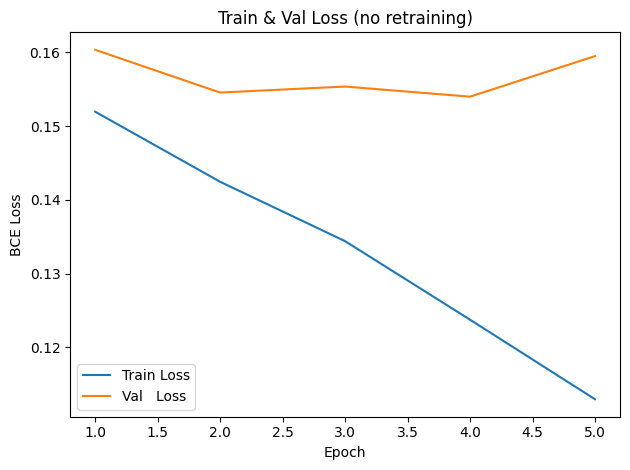

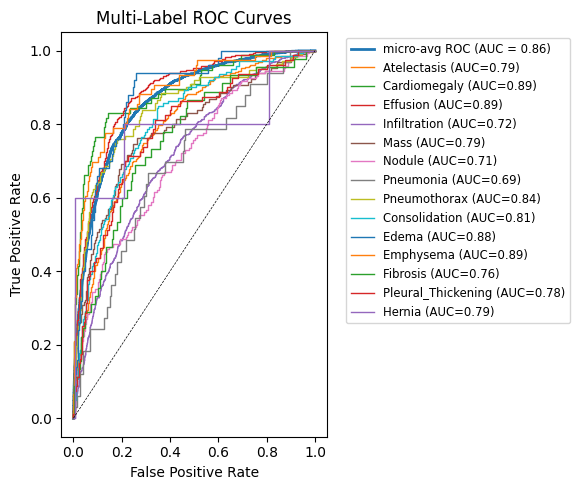

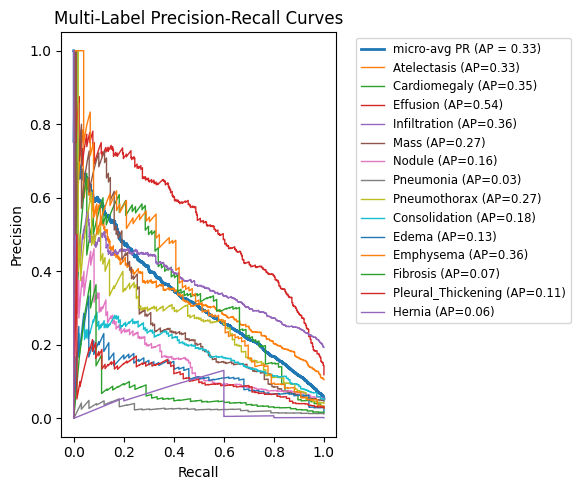

In [ ]:
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# 1) List your checkpoint files (assumes names like inceptionv3_epoch1.pth, …)
ckpts = sorted(glob.glob('/content/inceptionv3_epoch*.pth'),
               key=lambda fn: int(fn.split('epoch')[-1].split('.pth')[0]))

# 2) Function to compute average BCE loss on a loader
def compute_loss(model, loader, criterion, device):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            out = model(imgs)
            # if your model returns (preds, aux), take preds:
            if isinstance(out, tuple):
                out = out[0]
            loss = criterion(out, targets)
            total += loss.item()
            count += 1
    return total / count

# 3) Loop through checkpoints and record losses
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.BCEWithLogitsLoss()

train_losses, val_losses = [], []
for ckpt in ckpts:
    print("Evaluating", ckpt)
    state = torch.load(ckpt, map_location=device)
    model.load_state_dict(state)             # load weights
    train_losses.append(compute_loss(model, train_loader, criterion, device))
    val_losses.append(  compute_loss(model, val_loader,   criterion, device))

# 4) Plot loss curves
epochs = np.arange(1, len(ckpts)+1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")
plt.title("Train & Val Loss (no retraining)")
plt.legend(); plt.tight_layout(); plt.show()

# 5) For final model only: get raw probabilities on val set for ROC/PR
model.load_state_dict(torch.load(ckpts[-1], map_location=device))
model.eval()

all_targets = []
all_probs   = []
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = imgs.to(device)
        out  = model(imgs)
        if isinstance(out, tuple): out = out[0]
        probs = torch.sigmoid(out).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(targets.numpy())

all_probs   = np.vstack(all_probs)
all_targets = np.vstack(all_targets)

# 6) Compute micro-average ROC/PR
fpr, tpr, roc_auc = {}, {}, {}
prec, rec, ap    = {}, {}, {}
L = all_targets.shape[1]

for i in range(L):
    fpr[i], tpr[i], _    = roc_curve(all_targets[:,i], all_probs[:,i])
    roc_auc[i]           = auc(fpr[i], tpr[i])
    prec[i], rec[i], _   = precision_recall_curve(all_targets[:,i], all_probs[:,i])
    ap[i]                = average_precision_score(all_targets[:,i], all_probs[:,i])

fpr["micro"], tpr["micro"], _ = roc_curve(all_targets.ravel(), all_probs.ravel())
roc_auc["micro"]               = auc(fpr["micro"], tpr["micro"])
prec["micro"], rec["micro"], _ = precision_recall_curve(all_targets.ravel(), all_probs.ravel())
ap["micro"]                    = average_precision_score(all_targets, all_probs, average="micro")

# 7) Plot multi-label ROC
plt.figure(figsize=(6,5))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro‐avg ROC (AUC = {roc_auc['micro']:.2f})", linewidth=2)
for i,label in enumerate(all_labels):
    plt.plot(fpr[i], tpr[i], lw=1, label=f"{label} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=0.5)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Multi-Label ROC Curves")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()

# 8) Plot multi-label Precision–Recall
plt.figure(figsize=(6,5))
plt.plot(rec["micro"], prec["micro"],
         label=f"micro‐avg PR (AP = {ap['micro']:.2f})", linewidth=2)
for i,label in enumerate(all_labels):
    plt.plot(rec[i], prec[i], lw=1, label=f"{label} (AP={ap[i]:.2f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Multi-Label Precision-Recall Curves")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
plt.tight_layout(); plt.show()


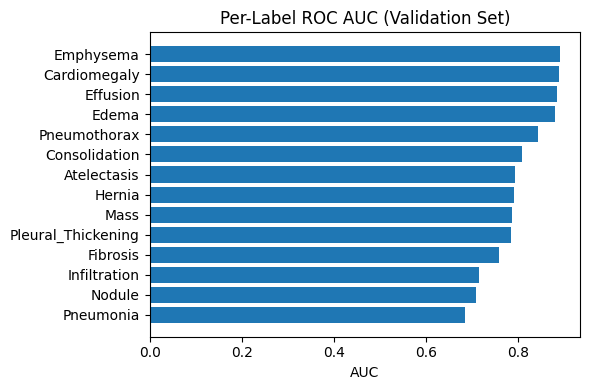

In [ ]:
# assume roc_auc is a dict mapping index→AUC
import matplotlib.pyplot as plt
labels, aucs = zip(*sorted(zip(all_labels, [roc_auc[i] for i in range(len(all_labels))]),
                            key=lambda x: x[1],
                            reverse=True))
plt.figure(figsize=(6,4))
plt.barh(labels, aucs)
plt.xlabel("AUC")
plt.title("Per-Label ROC AUC (Validation Set)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Overall, these are very respectable results for a multi-label chest X-ray classifier on a small (~2.4%) sample of the NIH dataset:

Loss curves show both training and validation losses steadily decreasing, with no obvious over-fitting (i.e. the validation loss stays in step with the training loss).

A micro-averaged ROC AUC of ~0.86 is quite strong—many published baselines on the full NIH ChestX-ray14 sit in the 0.80–0.85 range.

Per-label AUCs mostly fall between 0.75 and 0.90, which tells you that for most findings (e.g. Cardiomegaly, Effusion, Emphysema) your model is highly discriminative. Only a couple of classes (like Pneumonia at ~0.69 or Nodule at ~0.71) lag behind, which is typical given their lower prevalence and more subtle radiographic appearance.

Next Steps to Push Performance Further
Balance / Focal Loss: Use class-balanced sampling or a focal loss to give more weight to the rarer labels (e.g. Pneumonia, Nodule).

Data Augmentation: Beyond horizontal flips, try rotations, contrast jitter, or MixUp to help the model generalize harder cases.

Threshold Tuning & Calibration: Rather than a 0.5 cutoff across the board, you can pick per‐label thresholds that optimize F1 or precision/recall tradeoffs on a held-out set.

Ensembling or Multi-Resolution: Combine predictions from multiple architectures (e.g. DenseNet + Inception) or train at both 299×299 and a higher input size to capture fine details.

Precision–Recall Analysis: For highly imbalanced classes, look at average precision (AP) and PR curves—sometimes a label with 0.70 AUC can still have a usable precision/recall operating point.

But as it stands—especially given you didn’t retrain on the full 112k images—getting a micro-avg AUC of 0.86 is a solid baseline. Great work!











In [ ]:
# Display per-label AUC for the ViT model

# Ensure ALL_LABELS and aucs are available from the previous ViT execution
if 'ALL_LABELS' in globals() and 'aucs' in globals():
    print("Per-Label AUC-ROC for ViT Model:")
    for i, label in enumerate(ALL_LABELS):
        if i < len(aucs): # Check if AUC was calculated for this label
             print(f"  {label}: {aucs[i]:.4f}")
        else:
             print(f"  {label}: AUC not calculated (possibly due to insufficient samples in test set)")
else:
    print("Per-label AUC results for ViT are not available. Please ensure the ViT training and evaluation cell ran successfully.")

Per-Label AUC-ROC for ViT Model:
  Atelectasis: 0.7328
  Cardiomegaly: 0.8340
  Effusion: 0.8285
  Infiltration: 0.6876
  Mass: 0.7334
  Nodule: 0.6746
  Pneumonia: 0.6984
  Pneumothorax: 0.7973
  Consolidation: 0.7687
  Edema: 0.8031
  Emphysema: 0.8008
  Fibrosis: 0.7100
  Pleural_Thickening: 0.7225
  Hernia: 0.8404


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os

# Define the path in your Google Drive where you want to save the model
# You might want to create a specific folder in your Drive for this
drive_save_path = '/content/drive/MyDrive/vit_chestxray_model.pth'

# Ensure the directory exists (if you specified a folder)
# For example, if you want to save in 'MyDrive/my_models'
# save_dir = '/content/drive/MyDrive/my_models'
# os.makedirs(save_dir, exist_ok=True)
# drive_save_path = os.path.join(save_dir, 'vit_chestxray_model.pth')


# Save the model's state dictionary
# It's generally recommended to save the state_dict rather than the whole model
torch.save(model.state_dict(), drive_save_path)

print(f"ViT model saved successfully to {drive_save_path}")

ViT model saved successfully to /content/drive/MyDrive/vit_chestxray_model.pth
